# H2O Uplift Distributed Random Forest 

### Author: Veronika Maurerova veronika.maurerova@h2o.ai

## Modeling Uplift 

Distributed Uplift Random Forest (Uplift DRF) is a classification tool for modeling uplift - the incremental impact of a treatment. This tool is very useful for example in marketing or in medicine. This machine learning approach is inspired by the A/B testing method. 

To model uplift, the analyst needs to collect data specifically - before the experiment, the objects are divided usually into two groups: 

- **treatment group**: receive some kind of treatment (for example customer get some type of discount) 
- **control group**: is separated from the treatment (customers in this group get no discount). 

Then the data are prepared and an analyst can gather information about the response - for example, whether customers bought a product, patients recovered from the disease, or similar. 

## Uplift approaches 

There are several approaches to model uplift: 

- Meta-learner algorithms
- Instrumental variables algorithms
- Neural-networks-based algorithms
- Tree-based algorithms 



## Tree Based Uplift Algorithm

Tree-based algorithm means in every tree, it takes information about treatment/control group assignment and information about response directly into a decision about splitting a node. The uplift score is the criterion to make a decision similar to the Gini coefficient in the standard decision tree. 

**Uplift metric to decide best split**

The goal is to maximize the differences between the class distributions in the treatment and control sets, so the splitting criteria are based on distribution divergences. The distribution divergence is calculated based on the ``uplift_metric`` parameter. In H2O-3, three ``uplift_metric`` types are supported:

- **Kullback-Leibler divergence** (``uplift_metric="KL"``) - uses logarithms to calculate divergence, asymmetric, widely used, tends to infinity values (if treatment or control group distributions contain zero values). 

$ KL(P, Q) = \sum_{i=0}^{N} p_i \log{\frac{p_i}{q_i}}$

- **Squared Euclidean distance** (``uplift_metric="euclidean"``) - symmetric and stable distribution, does not tend to infinity values. 

$ E(P, Q) = \sum_{i=0}^{N} (p_i-q_i)^2$


- **Chi-squared divergence** (``uplift_metric="chi_squared"``) - Euclidean divergence normalized by control group distribution. Asymmetric and also tends to infinity values (if control group distribution contains zero values). 

$X^2(P, Q) = \sum_{i=0}^{N} \frac{(p_i-q_i)^2}{q_i}$

where:

- $P$ is treatment group distribution

- $Q$ is control group distribution

In a tree node the result value for a split is sum: $metric(P, Q) + metric(1-P, 1-Q)$. 

For the split gain value, the result within the node is normalized using a Gini coefficient (Eclidean or ChiSquared) or entropy (KL) for each distribution before and after the split.


**Uplift score in each leaf is calculated as:**

- $TP = (TY1 + 1) / (T + 2)$
- $CP = (CY1 + 1) / (C + 2)$
- $uplift\_score = TP - CP $

where:
- $T$ how many observations in a leaf are from the treatment group (how many data rows in a leaf have ``treatment_column`` label == 1) 
- $C$ how many observations in a leaf are from the control group (how many data rows in the leaf have ``treatment_column`` label == 0)
- $TY1$ how many observations in a leaf are from the treatment group and respond to the offer (how many data rows in the leaf have ``treatment_column`` label == 1 and ``response_column`` label == 1)
- $CY1$ how many observations in a leaf are from the control group and respond to the offer (how many data rows in the leaf have ``treatment_column`` label == 0 and ``response_column`` label == 1)

**Note**: A higher uplift score means more observations from treatment group respond to the offer than from control group. Which means offered treatment has positive effect. The uplift score can be negative, if more observations from control group respond to the offer without treatment.

<br>
<br>

![Difference between SDT and Uplift DT](https://blog.h2o.ai/wp-content/uploads/2022/01/tree.png)




## H2O Implementation (Major release 3.36)

The H2O-3 implementation of Uplift DRF is based on DRF because the principle of training is similar to DRF. It is tree based uplift algorithm. Uplift DRF generates a forest of classification uplift trees, rather than a single classification tree. Each of these trees is a weak learner built on a subset of rows and columns. More trees will reduce the variance. Classification takes the average prediction over all of their trees to make a final prediction. 

Currently, in H2O-3 only binomial trees are supported, as well as the uplift curve metric and Area Under Uplift curve (AUUC) metric, normalized AUUC, and the Qini value. We are working on adding also regression trees and more metrics, for example, Qini coefficient, and more. 

## Start H2O-3

In [2]:
import h2o
from h2o.estimators.uplift_random_forest import H2OUpliftRandomForestEstimator

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style

import pandas as pd

## Load data

To demonstrate how Uplift DRF works, Criteo dataset is used. 

**Source:**

Diemert Eustache, Betlei Artem} and Renaudin, Christophe and Massih-Reza, Amini, "A Large Scale Benchmark for Uplift Modeling", ACM, Proceedings of the AdKDD and TargetAd Workshop, KDD, London,United Kingdom, August, 20, 2018, https://ailab.criteo.com/criteo-uplift-prediction-dataset/.



**Description:**

- The dataset was created by The Criteo AI Lab
- Consists of 13M rows, each one representing a user with 12 features, a treatment indicator and 2 binary labels (visits and conversions).
- Positive labels mean the user visited/converted on the advertiser website during the test period (2 weeks).
- The global treatment ratio is 84.6%.

**Detailed description of the columns:**

- **f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11**: feature values (dense, float)
- **treatment**: treatment group (1 = treated, 0 = control)
- **conversion**: whether a conversion occured for this user (binary, label)
- **visit**: whether a visit occured for this user (binary, label)
- **exposure**: treatment effect, whether the user has been effectively exposed (binary)

In [4]:
control_name = "control"
treatment_column = "treatment"
response_column = "visit"
feature_cols = ["f"+str(x) for x in range(0,12)]

df = pd.read_csv("https://s3.amazonaws.com/h2o-public-test-data/bigdata/server/criteo-uplift-v2.1.csv")
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


## Prepare data

Inspiration from: https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/notebook

To modeling uplift the treatment and control group data have to have similar distribution. In real world usually the control group is smaller than the treatment group. It is also a case of Crieteo dataset and we have to rebalanced the data to have a similar size.

In [5]:
print('Total number of samples: {}'.format(len(df)))
print('The dataset is largely imbalanced: ')
print(df['treatment'].value_counts(normalize = True))
print('Percentage of users that visit: {}%'.format(100*round(df['visit'].mean(),4)))
print('Percentage of users that convert: {}%'.format(100*round(df['conversion'].mean(),4)))
print('Percentage of visitors that convert: {}%'.format(100*round(df[df["visit"]==1]["conversion"].mean(),4)))

Total number of samples: 13979592
The dataset is largely imbalanced: 
1    0.85
0    0.15
Name: treatment, dtype: float64
Percentage of users that visit: 4.7%
Percentage of users that convert: 0.29%
Percentage of visitors that convert: 6.21%


Class 0: 2096937
Class 1: 11882655
Proportion: 6 : 1


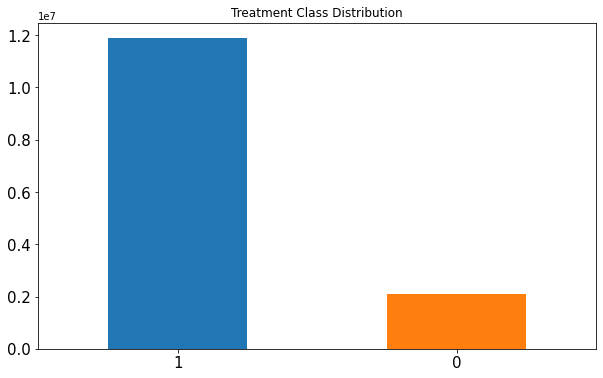

In [6]:
# Print proportion of a binary column
# https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/notebook
def print_proportion(df, column):
    fig = plt.figure(figsize = (10,6))
    target_count = df[column].value_counts()
    print('Class 0:', target_count[0])
    print('Class 1:', target_count[1])
    print('Proportion:', int(round(target_count[1] / target_count[0])), ': 1')
    target_count.plot(kind='bar', title='Treatment Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
    plt.xticks(rotation=0) 
    
print_proportion(df, treatment_column)

In [7]:
from sklearn.model_selection import train_test_split
train_df, test_df  = train_test_split(df, test_size=0.2, random_state=42, stratify=df['treatment'])
print(train_df.shape)
print(test_df.shape)

(11183673, 16)
(2795919, 16)


In [8]:
del(df)

Class 0: 1677550
Class 1: 9506123
Proportion: 6 : 1


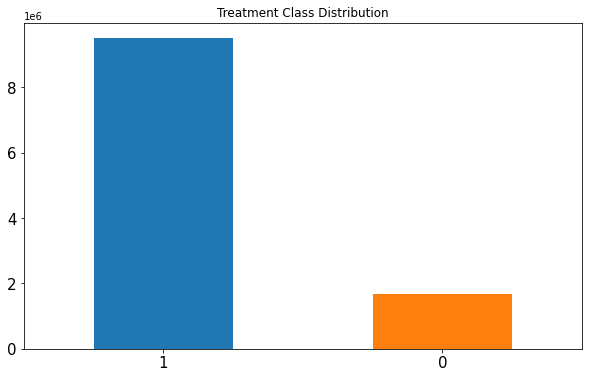

In [9]:
print_proportion(train_df, treatment_column)

In [10]:
# Random Undersampling (finding the majority class and undersampling it)
# https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/notebook
def random_under(df, feature):
    
    target = df[feature].value_counts()
    
    if target.values[0]<target.values[1]:
        under = target.index.values[1]
    
    else: 
        under = target.index.values[0]
        
    df_0 = df[df[feature] != under]
    df_1 = df[df[feature] == under]
    
    df_treatment_under = df_1.sample(len(df_0))
    df_1 = pd.concat([df_treatment_under, df_0], axis=0)
    
    return df_1

In [11]:
train_df = random_under(train_df, treatment_column)

Class 0: 1677550
Class 1: 1677550
Proportion: 1 : 1


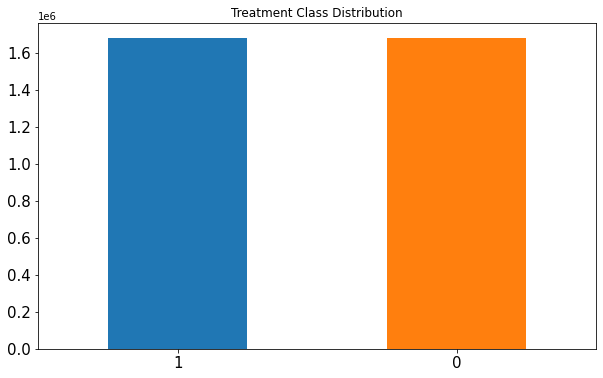

In [12]:
print_proportion(train_df, treatment_column)

In [13]:
# method to transfor data for LGWUM method, will be explained later
def target_class_lgwum(df, treatment, target, column_name):
    
    #CN:
    df[column_name] = 0 
    #CR:
    df.loc[(df[treatment] == 0) & (df[target] != 0), column_name] = 1 
    #TN:
    df.loc[(df[treatment] != 0) & (df[target] == 0), column_name] = 2 
    #TR:
    df.loc[(df[treatment] != 0) & (df[target] != 0), column_name] = 3 
    return df

response_column_lgwum = "lqwum_response"
train_df = target_class_lgwum(train_df, treatment_column, response_column, response_column_lgwum)
test_df = target_class_lgwum(test_df, treatment_column, response_column, response_column_lgwum)

## Start H2O

In [14]:
h2o.init(strict_version_check=False) # max_mem_size=10

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.99999
H2O_cluster_version_age:,15 minutes
H2O_cluster_name:,mori
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.113 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


## Import data to H2O

In [15]:
h2o_train_df = h2o.H2OFrame(train_df)
del(train_df)

h2o_train_df[treatment_column] = h2o_train_df[treatment_column].asfactor()
h2o_train_df[response_column] = h2o_train_df[response_column].asfactor()
h2o_train_df[response_column_lgwum] = h2o_train_df[response_column_lgwum].asfactor()
h2o_train_df = h2o.assign(h2o_train_df, "train_df")

h2o_test_df = h2o.H2OFrame(test_df)
del(test_df)
h2o_test_df[treatment_column] = h2o_test_df[treatment_column].asfactor()
h2o_test_df[response_column] = h2o_test_df[response_column].asfactor()
h2o_test_df[response_column_lgwum] = h2o_test_df[response_column_lgwum].asfactor()
h2o_test_df = h2o.assign(h2o_test_df, "test_df")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


## Train H2O UpliftDRF model

In [16]:
ntree = 20
max_depth = 15
metric="Euclidean"

h2o_uplift_model = H2OUpliftRandomForestEstimator(
                    ntrees=ntree,
                    max_depth=max_depth,
                    min_rows=30,
                    nbins=1000,
                    sample_rate=0.80,
                    score_each_iteration=True,
                    treatment_column=treatment_column,
                    uplift_metric=metric,
                    auuc_nbins=1000,
                    auuc_type="gain",
                    seed=42)

h2o_uplift_model.train(y=response_column, x=feature_cols, training_frame=h2o_train_df)
h2o_uplift_model

upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OUpliftRandomForestEstimator : Uplift Distributed Random Forest
Model Key: UpliftDRF_model_python_1689859822235_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    20                 40                          152147                 15           15           15            226           375           299.6

ModelMetricsBinomialUplift: upliftdrf
** Reported on train data. **

AUUC: 27653.366951809396
AUUC normalized: 0.835449152622639

AUUC table (number of bins: 975): All types of AUUC value
uplift_type        qini      lift        gain
-----------------  --------  ----------  --------
AUUC value         13950.4   0.0255259   27653.4
AUUC normalized    0.842922  0.0255259   0.835449
AUUC random value  8284.88   0.00493868  16569.8

Qini value: 5665.486356483165

AECU values table: All types of AECU value
uplift_type    qini     lift       gain
-------------  -------  ---------  -------
AECU value     5665.49  0.0205872  11083.6

Scoring History: 
     timestamp            duration          number_of_trees    training_auuc_nbins    training_auuc       training_auuc_normalized    training_qini_value
---  -------------------  ----------------  -----------------  ---------------------  ------------------  --------------------------  ---------------------
     2023-07-20 15:32:20  0.087 sec         0.0                0                      nan                 nan                         nan
     2023-07-20 15:32:25  5.001 sec         1.0                16                     27654.759831086874  0.8354912335675794          145.19794681488565
     2023-07-20 15:32:41  20.732 sec        2.0                36                     24922.98602904925   0.7529603029924244          659.4607746892107
     2023-07-20 15:32:56  35.267 sec        3.0                61                     23986.477619947054  0.7246669975814823          1427.558100645023
     2023-07-20 15:33:11  51.081 sec        4.0                97                     23745.531903706986  0.7173876708068577          2139.2136934188948
     2023-07-20 15:33:28  1 min  7.611 sec  5.0                141                    23853.273731581452  0.7206427109239109          2742.899583815666
     2023-07-20 15:33:46  1 min 25.335 sec  6.0                208                    24297.46503748926   0.7340623878395549          3312.8830197257194
     2023-07-20 15:34:04  1 min 43.525 sec  7.0                277                    24783.70521693464   0.7487524234723456          3782.8342577077
     2023-07-20 15:34:26  2 min  6.050 sec  8.0                363                    25383.21628060475   0.7668645401995393          4234.377178706709
     2023-07-20 15:34:50  2 min 29.392 sec  9.0                455                    25490.020313292083  0.7700912481357123          4383.016776975463
---  ---                  ---               ---                ---                    ---                 ---                         ---
     2023-07-20 15:35:39  3 min 18.196 sec  11.0               625                    26207.635842620588  0.7917714756078731          4852.390298847275
     2023-07-20 15:36:04  3 min 43.319 sec  12.0               702                    26590.000175156056  0.8033232681316037          5071.457879669533
     2023-07-20 15:36:30  4 min  9.613 sec  13.0               763                    26767.16533556117   0.8086756898961089          5177.909341153823
     2023-07-20 15:36:57  4 min 36.351 sec  14.0               831                    27048.766708443647  0.8171832842430119          5333.618998341139
     2023-07-20 15:37:26  5 min  6.015 sec  15.0               881                    27155.990511849228  0.8204226740739939          5397.093335071517
     2023-07

## Predict and plot Uplift Score

In [17]:
# Plot uplift score
# source https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/notebook
def plot_uplift_score(uplift_score):
    plt.figure(figsize = (10,6))
    plt.xlim(-.05, .1)
    plt.hist(uplift_score, bins=1000, color=['#2077B4'])
    plt.xlabel('Uplift score')
    plt.ylabel('Number of observations in validation set')

In [18]:
h2o_uplift_pred = h2o_uplift_model.predict(h2o_test_df)
h2o_uplift_pred

upliftdrf prediction progress: |█████████████████████████████████████████████████| (done) 100%


uplift_predict,p_y1_with_treatment,p_y1_without_treatment
0.000583659,0.00167115,0.00108749
0.000583659,0.00167115,0.00108749
0.000583659,0.00167115,0.00108749
0.0441309,0.0987045,0.0545736
0.000583659,0.00167115,0.00108749
0.000583659,0.00167115,0.00108749
0.000583659,0.00167115,0.00108749
0.00112479,0.0346892,0.0335644
0.000583659,0.00167115,0.00108749
0.000583659,0.00167115,0.00108749


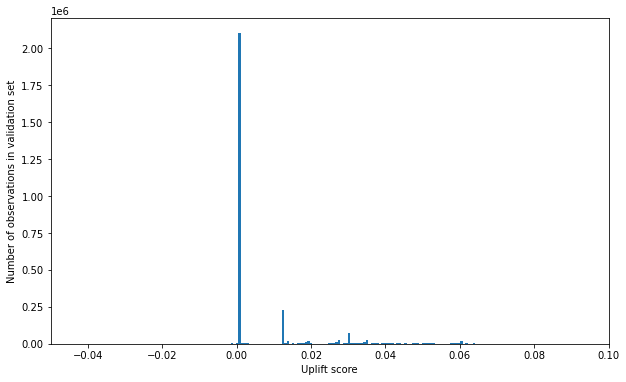

In [19]:
plot_uplift_score(h2o_uplift_pred['uplift_predict'].as_data_frame().uplift_predict)

## Evaluate the model

In [20]:
perf_h2o = h2o_uplift_model.model_performance(h2o_test_df)



### Area Under Uplift Curve (AUUC) calculation

To calculate AUUC for big data, the predictions are binned to histograms. Due to this feature the results should be different compared to exact computation.

To define AUUC, binned predictions are sorted from largest to smallest value. For every group the cumulative sum of observations statistic is calculated. The uplift is defined based on these statistics.


#### Types of AUUC


| AUUC type | &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; Formula &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;|
|:----------:|:-------------------------------------------:|
| **Qini**   | $TY1 - CY1 * \frac{T}{C}$                   |
| **Lift**   | $\frac{TY1}{T} - \frac{CY1}{C}$             |
| **Gain**   | $(\frac{TY1}{T} - \frac{CY1}{C}) * (T + C)$ |


Where:

- **T** how many observations are in the treatment group (how many data rows in the bin have treatment_column label == 1)
- **C** how many observations are in the control group (how many data rows in the bin have treatment_column label == 0)
- **TY1** how many observations are in the treatment group and respond to the offer (how many data rows in the bin have treatment_column label == 1 and response_column label == 1)
- **CY1** how many observations are in the control group and respond to the offer (how many data rows in the bin have treatment_column label == 0 and response_column label == 1)


The resulting AUUC value is:

- Not normalized.
- The result could be a positive or negative number.
- Higher number means better model.

More information about normalization is in **Normalized AUUC** section.


For some observation groups the results should be NaN. In this case, the results from NaN groups are linearly interpolated to calculate AUUC and plot uplift curve.


In [21]:
perf_h2o.auuc_table()

uplift_type,qini,lift,gain
AUUC value,21957.2812955,0.0239431,25778.1588999
AUUC normalized,0.8956995,0.0239431,0.8938296
AUUC random value,16257.7513719,0.0068410,19126.7594789


### Cumulative Uplift curve plot

To plot the uplift curve, the ``plot_uplift``method can be used. There is specific parameter ``metric`` which can be ``"qini", "gain", or "lift"``. The most popular is the Qini uplift curve which is similar to the ROC curve. The Gain and Lift curves are also known from traditional binomial models. 

Depending on these curves, you can decide how many observations (for example customers) from the test dataset you send an offer to get optimal gain.

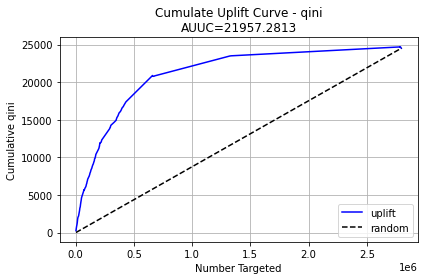

In [22]:
perf_h2o.plot_uplift(metric="qini")

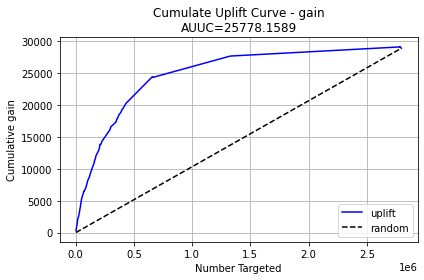

In [23]:
perf_h2o.plot_uplift(metric="gain")

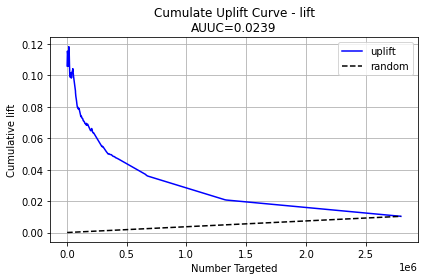

In [24]:
perf_h2o.plot_uplift(metric="lift")

### Qini value and Average Excess Cumulative Uplift (AECU)

Qini value is calculated as the difference between the Qini AUUC and area under the random uplift curve (random AUUC). The random AUUC is computed as diagonal from zero to overall gain uplift. 

The Qini value can be generalized for all AUUC metric types. So AECU for Qini metric is the same as Qini value, but the AECU can be also calculated for Gain and Lift metric type. These values are stored in ``aecu_table``.


In [25]:
perf_h2o.aecu_table()

uplift_type,qini,lift,gain
AECU value,5699.5299236,0.0171021,6651.3994210


### Normalized AUUC

To get normalized AUUC, you have to call ``auuc_normalized`` method. The normalized AUUC is calculated from uplift values which are normalized by uplift value from maximal treated number of observations. So if you have for example uplift values [10, 20, 30] the normalized uplift is [1/3, 2/3, 1]. If the maximal value is negative, the normalization factor is the absolute value from this number. The normalized AUUC can be again negative and positive and can be outside of (0, 1) interval. The normalized AUUC for ``auuc_metric="lift"`` is not defined, so the normalized AUUC = AUUC for this case. Also the ``plot_uplift`` with ``metric="lift"`` is the same for ``normalize=False`` and ``normalize=True``.


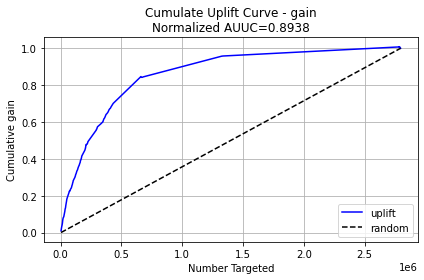

In [26]:
perf_h2o.plot_uplift(metric="gain", normalize=True)

In [27]:
perf_h2o.auuc_normalized()

0.8938295747088778

### Scoring histrory and importance of number of trees

To speed up the calculation of AUUC, the predictions are binned into quantile histograms. To calculate precision AUUC the more bins the better. The more trees usually produce more various predictions and then the algorithm creates histograms with more bins. So the algorithm needs more iterations to get meaningful AUUC results. 
You can see in the scoring history table the number of bins as well as the result AUUC. There is also Qini value parameter, which reflects the number of bins and then is a better pointer of the model improvement. In the scoring history table below you can see the algorithm stabilized after building 6 trees. But it depends on data and model settings on how many trees are necessary.

In [28]:
h2o_uplift_model.scoring_history()

,,timestamp,duration,number_of_trees,training_auuc_nbins,training_auuc,training_auuc_normalized,training_qini_value
0,,2023-07-20 15:32:20,0.087 sec,0.0,0,NaN,NaN,NaN
1,,2023-07-20 15:32:25,5.001 sec,1.0,16,27654.759831,0.835491,145.197947
2,,2023-07-20 15:32:41,20.732 sec,2.0,36,24922.986029,0.752960,659.460775
3,,2023-07-20 15:32:56,35.267 sec,3.0,61,23986.477620,0.724667,1427.558101
4,,2023-07-20 15:33:11,51.081 sec,4.0,97,23745.531904,0.717388,2139.213693
5,,2023-07-20 15:33:28,1 min 7.611 sec,5.0,141,23853.273732,0.720643,2742.899584
6,,2023-07-20 15:33:46,1 min 25.335 sec,6.0,208,24297.465037,0.734062,3312.883020
7,,2023-07-20 15:34:04,1 min 43.525 sec,7.0,277,24783.705217,0.748752,3782.834258
8,,2023-07-20 15:34:26,2 min 6.050 sec,8.0,363,25383.216281,0.766865,4234.377179
9,,2023-07-20 15:34:50,2 min 29.392 sec,9.0,455,25490.020313,0.770091,4383.016777


## Comparasion Tree-based approach and Generalized Weighed Uplift (LGWUM)

LGWUM (Kane et al., 2014) is one of several methods available for Uplift Modeling, and uses an approach to Uplift Modelling better known as Class Variable Transformation. LGWUM assumes that positive uplift lies in treating treatment-group responders (TR) and control-group non-responders (CN), whilst avoiding treatment-group non-responders (TN) and control-group responders (CR). This is visually shown as:

𝑈𝑝𝑙𝑖𝑓𝑡 𝐿𝐺𝑊𝑈𝑀 = P(TR)/P(T) + P(CN)/P(C) - P(TN)/P(T) - P(CR)/P(C)

source: https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/notebook

In [29]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

h2o_gbm_lgwum = H2OGradientBoostingEstimator(ntrees=ntree,
                                       max_depth=max_depth,
                                       min_rows=30,
                                       nbins=1000,
                                       score_each_iteration=False,
                                       seed=42)

h2o_gbm_lgwum.train(y=response_column_lgwum, x=feature_cols, training_frame=h2o_train_df)
h2o_gbm_lgwum

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1689859822235_24


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    20                 80                          3.98939e+06            15           15           15            1336          7040          3969.32

ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.31190785343648125
RMSE: 0.5584871112536808
LogLoss: 0.8285843718112937
Mean Per-Class Error: 0.5822510845469803
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0            1      2       3      Error      Rate
-----------  -----  ------  -----  ---------  ---------------------
1.47138e+06  3497   130706  7860   0.0880495  142,063 / 1,613,445
23449        14885  17613   8158   0.767803   49,220 / 64,105
1.32915e+06  3522   256258  7966   0.839527   1,340,637 / 1,596,895
26155        2917   22033   29550  0.633625   51,105 / 80,655
2.85014e+06  24821  426610  53534  0.471826   1,583,025 / 3,355,100

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.528173
2    0.970762
3    0.993764
4    1

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse       training_logloss    training_classification_error    training_auc    training_pr_auc
---  -------------------  ----------------  -----------------  ------------------  ------------------  -------------------------------  --------------  -----------------
     2023-07-20 15:41:27  0.029 sec         0.0                0.75                1.3862943611201621  0.54084677058806                 nan             nan
     2023-07-20 15:41:43  16.020 sec        1.0                0.7273500276934312  1.2998643998347224  0.49760245596256447              nan             nan
     2023-07-20 15:41:58  31.267 sec        2.0                0.7072114503050211  1.2292086519554999  0.49306727072218415              nan             nan
     2023-07-20 15:42:13  45.968 sec        3.0                0.6892734700013863  1.1704852612632415  0.4898101397871896               nan             nan
     2023-07-20 15:42:27  59.670 sec        4.0                0.6733152317145654  1.121179483747584   0.4879553515543501               nan             nan
     2023-07-20 15:42:40  1 min 13.559 sec  5.0                0.6590825290094642  1.0793035991503663  0.4860174063366219               nan             nan
     2023-07-20 15:42:54  1 min 26.651 sec  6.0                0.6463787602453364  1.0434637681914327  0.4845158117492772               nan             nan
     2023-07-20 15:43:06  1 min 38.976 sec  7.0                0.6350349355342839  1.0126009508204046  0.48314357247175943              nan             nan
     2023-07-20 15:43:17  1 min 50.555 sec  8.0                0.6248829282266323  0.9858406572017421  0.48195731870883135              nan             nan
     2023-07-20 15:43:31  2 min  4.354 sec  9.0                0.6157753561494564  0.9624884977231626  0.4808303776340497               nan             nan
---  ---                  ---               ---                ---                 ---                 ---                              ---             ---
     2023-07-20 15:43:53  2 min 26.563 sec  11.0               0.6001792474804977  0.9238656584368838  0.4783156984888677               nan             nan
     2023-07-20 15:44:04  2 m

In [30]:
uplift_predict_lgwum = h2o_gbm_lgwum.predict(h2o_test_df)

result = uplift_predict_lgwum.as_data_frame()
result.columns = ['predict', 'p_cn', 'p_cr', 'p_tn', 'p_tr']
result['uplift_score'] = result.eval('\
                                p_cn/(p_cn + p_cr) \
                                + p_tr/(p_tn + p_tr) \
                                - p_tn/(p_tn + p_tr) \
                                - p_cr/(p_cn + p_cr)')
result

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,predict,p_cn,p_cr,p_tn,p_tr,uplift_score
0,0,0.462914,0.039050,0.459005,0.039032,0.001154
1,2,0.459171,0.040068,0.460331,0.040430,0.000960
2,0,0.461210,0.039238,0.459893,0.039659,0.001968
3,2,0.451050,0.043022,0.451416,0.054511,0.041337
4,0,0.462915,0.039050,0.459006,0.039029,0.001144
...,...,...,...,...,...,...
2795914,2,0.262453,0.210295,0.291141,0.236111,0.005958
2795915,0,0.490065,0.081051,0.337942,0.090942,0.140252
2795916,0,0.463028,0.039023,0.458692,0.039257,0.002219
2795917,2,0.448384,0.051104,0.450981,0.049531,-0.006707


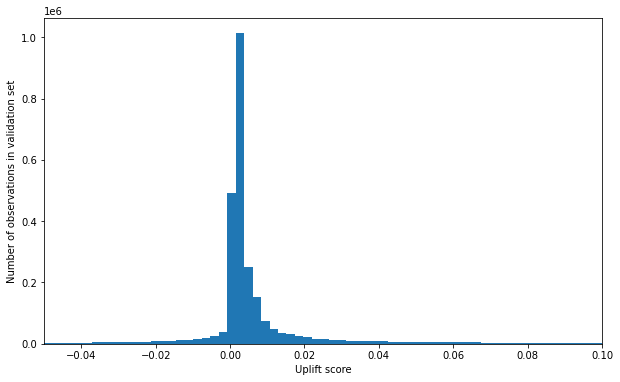

In [31]:
plot_uplift_score(result.uplift_score)

In [32]:
lgwum_predict = h2o.H2OFrame(result['uplift_score'].tolist())
perf_lgwum = h2o.make_metrics(lgwum_predict, h2o_test_df[response_column], treatment=h2o_test_df[treatment_column], auuc_type="gain", auuc_nbins=81)
perf_lgwum

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


uplift_type,qini,lift,gain
AUUC value,17984.8660027,0.0243477,21114.0696363
AUUC normalized,0.7336534,0.0243477,0.7321074
AUUC random value,12495.7909868,0.0052580,14700.9253147
uplift_type,qini,lift,gain
AECU value,5489.0750160,0.0190897,6413.1443216


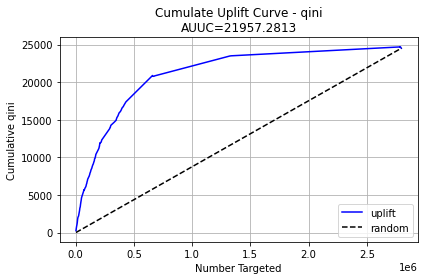

In [33]:
perf_h2o.plot_uplift(metric="qini")

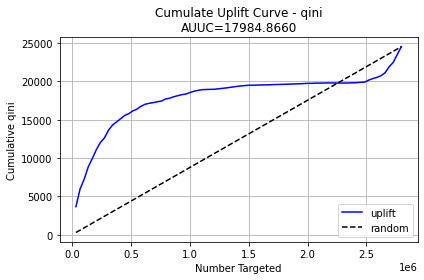

In [34]:
perf_lgwum.plot_uplift(metric="qini")

### Conclusion
From the Qini curves, you can see the Uplift DRF algorithm performs better than the LGWUM algorithm. The main reason is, that the split in Uplift DRF can be more precious thanks to information about both treatment and control groups.

## Uplift trees modeling sources:

- N. J. Radcliffe, and P. D. Surry, “Real-World Uplift Modelling withSignificance-Based Uplift Trees”, Stochastic Solutions White Paper, 2011.

- P. D. Surry, and N. J. Radcliffe, “Quality measures for uplift models”, 2011.

## References

- P. Rzepakowski, and S. Jaroszewicz, “Decision trees for uplift modeling with single and multiple treatments”, 2012.

- Hugh Huyton, “Criteo Uplift Modelling“, 2021, https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/notebook.
